# LSI demonstrator
In this tutorial, you will learn how to use Latent Semantic Analysis to either discover hidden topics from given documents in an unsupervised way or use LSA values as a feature vectors to classify document with known document categories.

## Quick reminder of LSI/LSA
Given a set of $Nd$ documents involving $Nw$ distinct words. The first step consist on building a term-document matrix $X$ of shape $(Nw, Nd)$.
LSI uses *SVD* (singular value decomposition) to emphasis latent topics, projecting the data in a new vectorial space as $X = T_0S_0D_0'$, where:
 - $T_0$ is matrix of size $(N_w, N_t)$
 - $S_0$ is a diagonal matrix of size $(N_t, N_t)$
 - $D_0'$ is a matrix of size $(N_t, N_d)$
        

$N_t$ have to be fixed as $N_t ≤ min(N_w, N_d)$ and $S_0$ is sorted in descending order. With these contraints, only one decomposition exist.

As explained during the lecture, the bag of word representation (TF or TFIDF) matrix ($X$ in the notation above) contains a lot of noise. In fact, this matrix can be very sparse. More precisely, this noise can be removed by filtering the values of $S_0$ with low values (or force them to 0s). 

Consequently, $S_0$ dimension is decreased to $k$ according to the filtering given above. This parameter $k$ is crutial for the *LSI* implementation and usage.


        

In [39]:
!pip3 install gensim
!pip3 install nltk

In [40]:
#import modules
import os.path
import pandas as pd
import numpy as np
import re
from gensim import corpora, similarities
from gensim.test.utils import common_dictionary, common_corpus
from gensim.models import LsiModel
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sofianemedjkoune/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sofianemedjkoune/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [41]:
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

# Necessary functions

## Loading Data
Let's first create data load function for loading *bbcsport-fulltext.zip*. You can download the data [here](http://mlg.ucd.ie/files/datasets/bbcsport-fulltext.zip).

In [42]:
def load_data(dir_data="bbcsport/",nExpPerClass = 5):
    """
    Input  : path and nbSamples to load per class (None for all)
    Purpose: loading text files
    Output : data frame of descriptions with associated class
    """
    df_dataset = pd.DataFrame(columns=["sport_class", "description"], index=range(nExpPerClass * 5))
    counter = 0
    for i in range(1, nExpPerClass+1):
        for cl in ["athletics", "cricket", "football", "rugby", "tennis"]:
            if i < 10 : 
                name = dir_data+cl+"/00{}.txt".format(i)
            elif i < 100:
                name = dir_data+cl+"/0{}.txt".format(i)
            else:
                name = dir_data+cl+"/{}.txt".format(i)
            f = open(name)
            df_dataset.sport_class[counter] = cl
            df_dataset.description[counter] = " ".join(f.readlines())
            f.close()
            counter+=1
    return df_dataset

## Preprocessing Data
After data loading function, you need to preprocess the text. Following steps are taken to preprocess the text:
* Tokenize the text articles
* Remove stop words
* Perform stemming on text

In [43]:
def preprocess_data(raw_text):
    """
    Input  : raw text to clean
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    
    # create English stop words list
    en_stop = set(stopwords.words('english'))
    
    # Create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()
    
    # list for tokenized documents in loop
    df_dataset["cleaned_description"] = ""
    
    # clean and tokenize document string
    raw = raw_text.lower()
    tokens = tokenizer.tokenize(raw)
    
    # remove stop words from tokens
    stopped_tokens = [i for i in tokens if not i in en_stop]
    
    # stem tokens
    stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]

    return stemmed_tokens

## Prepare Corpus
Next step is to prepare corpus. Here, you need to create a document-term matrix and dictionary of terms.

### 1. Using "corpora" from gensim to extract vocabulary from a corpus

In [44]:
def get_dictionary(doc_clean):
    """
    Input  : clean document
    Purpose: get the whole associated vocabulary
    Output : term dictionary
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    return corpora.Dictionary(doc_clean)


### 2. Build TF-IDF matrix: TFIDF = TF * IDF

#### 2.1 Get a term frequency matrix from a corpus (TF part: without or with normalization)

In [45]:
def get_TF_matrix(doc_clean, useTransfertDict=True):
    """
    Input  : clean document
    Purpose: get the term frequency matrix from a corpus
    Output : Document Term Frequency Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. 
    dictionary = corpora.Dictionary(doc_clean)
        
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    return [dictionary.doc2bow(doc) for doc in doc_clean]
    

In [46]:
def get_normTF_matrix(doc_clean):
    """
    Input  : clean document
    Purpose: get the term frequency matrix from a corpus
    Output : Document Term Frequency Matrix
    """

    # Creating the term dictionary of our courpus, where every unique term is assigned an index. 
    dictionary = corpora.Dictionary(doc_clean)

    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    TFmat = pd.DataFrame(0,
                         columns=[i for i in range(len(doc_clean))],
                         index=[i for i in range(len(dictionary))]
                        )
    i=0
    for doc in doc_clean:
        vec = [0 for i in range(len(dictionary))]
        for wrd, freq in dictionary.doc2bow(doc):
            vec[wrd] = round(freq / len(doc), 4)
        TFmat[i] = vec
        i+=1
    return TFmat

#### 2.2 Get a IDF matrix 

In [47]:
def get_IDF_matrix(doc_clean, useTransfertDict=True):
    """
    Input  : clean document
    Purpose: create IDF matrix
    Output : IDF Matrix
    """
    # Create vocabulary
    if useTransfertDict:
        vocabulary = common_dictionary
    else:
        vocabulary = get_dictionary(doc_clean)
    
    # Creating tf matrix
    TF_matrix = get_TF_matrix(doc_clean)
    
    # Converting list of documents (corpus) into IDF Matrix using dictionary prepared above.
    word_idf_values = {i:0 for i in list(vocabulary.keys())}
    
    for w in range(len(vocabulary)): 
        for doc in TF_matrix:
            for wrd in doc:
                if w == wrd[0]:
                    word_idf_values[w]+=1
        word_idf_values[w] = np.log(len(doc_clean) / (1 + word_idf_values[w]))
    return word_idf_values

#### 2.3 Get the final TF-IDF matrix 

In [48]:
def get_TFIDF_matrix(doc_clean):
    """
    Input  : clean document
    Purpose: create TFIDF matrix
    Output : TFIDF Matrix
    """
    # Creating tf matrix
    TF_matrix = get_normTF_matrix(doc_clean)

    # Create IDF
    IDF_vector = get_IDF_matrix(doc_clean)

    # initialize TFIDF as TF
    TFIDF_matrix = TF_matrix.copy()
    
    # update TF Matrix using IDF term.
    for doc in range(len(doc_clean)):
        for word, score in IDF_vector.items():
            TFIDF_matrix[doc][word] = TFIDF_matrix[doc][word] * score
    return TFIDF_matrix

## Create an LSI model using Gensim
After corpus creation, you can generate a model using LSI.

### 1. Build LSI model

In [49]:
def create_gensim_lsi_model(clean_documents_list, k=None):
    """
    Input  : clean document, dictionary
    Purpose: create LSI model (Latent Semantic Indexing) 
             from corpus and dictionary
    Output : return LSI model
    """
    
    #LSI model consists of Singular Value Decomposition (SVD) of
    #Term Document Matrix M: M = T x S x D'
    #and dimensionality reductions of T, S and D ("Derivation")
    
    dictionary = get_dictionary(clean_documents_list)
    
    corpus = get_TF_matrix(clean_documents_list)
    if k is not None:
        lsi_model = LsiModel(
                corpus=corpus,
                id2word=dictionary,
                num_topics=int(k)
                )
    else:
            lsi_model = LsiModel(
            corpus=corpus,
            id2word=dictionary 
            )
    print(); print(); print("="*20, "Training LSI model report", "="*20); print()
    
    print("Initial TF matrix (NwordsXNdocuments): ")
    TF = []
    for x in corpus:
        wrds = [0 for i in range(len(dictionary))]
        for i, j in x: wrds[i] = j
        TF.append(wrds)
    print(pd.np.transpose(TF))
    print()
    print("Derivation of Term Matrix T of Training Document Word Stems: ")
    print(lsi_model.get_topics())
    print()
    #Derivation of Term Document Matrix of Training Document Word Stems = M' x [Derivation of T]
    print("LSI Vectors of Training Document Word Stems: ")
    print([lsi_model[document_word_stems] for document_word_stems in corpus])
    print("="*70); print(); print()
    return lsi_model

### 2. Get LSI vector

In [50]:
def get_lsi_vector(lsi_model, clean_text):
    return lsi_model[dictionary.doc2bow(clean_text)]

### 3. Choose k (dimension reduction)

In [51]:
def select_optimal_k_value(singular_values, significativity=75):
    singular_values.sort()
    lsi_model.projection.s = lsi_model.projection.s[::-1]
    sum_of_singular_values = sum(singular_values)
    s = 0; k = 0 
    while((s < significativity * sum_of_singular_values / 100) and 
          k < max(2, len(singular_values) - 2)):
        s+=singular_values[k]
        k+=1
    return(k)

## Classification task 

## 1. Training function

In [52]:
def distance_classifier_cosine_traning(lsi_vector_trainDB):
    """
    Input  : LSI vectors
    Purpose: calculate cosine similarity matrix
    Output : return similarity matrix
    """
    #calculate cosine similarity matrix for all training document LSI vectors
    return similarities.MatrixSimilarity(lsi_vector_trainDB)

## 2. Prediction function

In [53]:
def distance_classifier_cosine_test(classification_model, training_data, test_doc_lsi_vector, N=1):
    """
    Input  : trained classifier model, the training data (list of descriptions), lsi vectors of a document and N nearest document in the training data base
    Purpose: calculate cosine similarity matrix against all training samples
    Output : return nearest N document and classes
    """
    cosine_similarities = classification_model[test_doc_lsi_vector]

    most_similar_document_test = training_data[np.argmax(cosine_similarities)]

    #calculate cosine similarity matrix for all training document LSI vectors
    return most_similar_document_test

## 3. Accuracy calculation

In [54]:
def reco_rate(ref_labels, predicted_labels):
    commun_labels = (pd.np.array(ref_labels)==pd.np.array(predicted_labels)).sum()
    return 100 * commun_labels / len(ref_labels)


#  ===========
#  Main program
#  ===========

## Let's start with a toy example to handle the LSI concept

In [55]:
# load data
df_dataset = pd.DataFrame(["Artificial intelligence is fun",
                           "Data science is the future and data is the new black gold", 
                           "Business and data science / artificial intelligence combination is the key"],
                         columns=["description"])

df_dataset.head()

,description
0,Artificial intelligence is fun
1,Data science is the future and data is the new...
2,Business and data science / artificial intelli...


In [56]:
# clean
df_dataset["clean_description"] = df_dataset.description.apply(preprocess_data)
df_dataset.head()

,description,cleaned_description,clean_description
0,Artificial intelligence is fun,,"[artifici, intellig, fun]"
1,Data science is the future and data is the new...,,"[data, scienc, futur, data, new, black, gold]"
2,Business and data science / artificial intelli...,,"[busi, data, scienc, artifici, intellig, combi..."


In [57]:
# get vocabulary
dictionary = get_dictionary(df_dataset.clean_description)
for i,j in dictionary.items():
    print("word =", j, "--> ID =", i)


word = artifici --> ID = 0
word = fun --> ID = 1
word = intellig --> ID = 2
word = black --> ID = 3
word = data --> ID = 4
word = futur --> ID = 5
word = gold --> ID = 6
word = new --> ID = 7
word = scienc --> ID = 8
word = busi --> ID = 9
word = combin --> ID = 10
word = key --> ID = 11


### Analyse TFIDF matrix

In [58]:
# TFIDF matrix
corpus_TFIDFmatrix = get_TFIDF_matrix(df_dataset.clean_description)
corpus_TFIDFmatrix

,0,1,2
0,0.000000,0.000000,0.000000
1,0.135142,0.000000,0.000000
2,0.000000,0.000000,0.000000
3,0.000000,0.057941,0.000000
4,0.000000,0.000000,0.000000
5,0.000000,0.057941,0.000000
6,0.000000,0.057941,0.000000
7,0.000000,0.057941,0.000000
8,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.057941


#### --> What can we  observe ?

#### Build LSI model / vector

In [59]:
# train lsi model
lsi_model = create_gensim_lsi_model(df_dataset.clean_description)



==================== Training LSI model report ====================

Initial TF matrix (NwordsXNdocuments): 
[[1 0 1]
 [1 0 0]
 [1 0 1]
 [0 1 0]
 [0 2 1]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]]

Derivation of Term Matrix T of Training Document Word Stems: 
[[ 0.22378201  0.04330675  0.22378201  0.23189989  0.64427503  0.23189989
   0.23189989  0.23189989  0.41237514  0.18047525  0.18047525  0.18047525]
 [ 0.47023499  0.19913347  0.47023499 -0.24817149 -0.22524146 -0.24817149
  -0.24817149 -0.24817149  0.02293003  0.27110152  0.27110152  0.27110152]
 [ 0.29316126  0.62212685  0.29316126  0.13983558 -0.04929444  0.13983558
   0.13983558  0.13983558 -0.18913002 -0.32896559 -0.32896559 -0.32896559]]

LSI Vectors of Training Document Word Stems: 
[[(0, 0.4908707741824215), (1, 1.139603449726804), (2, 1.2084493619611538)], [(0, 2.628524740452253), (1, -1.4202388586420542), (2, 0.2716234033244088)], [(0, 2.045639951696584), (1, 1.5514631238169585), (2, -0.63899871945

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead


In [60]:
# Get the associated SVD decomposition

In [61]:
# singular values
lsi_model.projection.s

array([3.36671045, 2.39224001, 1.39371751])

In [62]:
# left singular vectors
lsi_model.projection.u

array([[ 0.22378201,  0.47023499,  0.29316126],
       [ 0.04330675,  0.19913347,  0.62212685],
       [ 0.22378201,  0.47023499,  0.29316126],
       [ 0.23189989, -0.24817149,  0.13983558],
       [ 0.64427503, -0.22524146, -0.04929444],
       [ 0.23189989, -0.24817149,  0.13983558],
       [ 0.23189989, -0.24817149,  0.13983558],
       [ 0.23189989, -0.24817149,  0.13983558],
       [ 0.41237514,  0.02293003, -0.18913002],
       [ 0.18047525,  0.27110152, -0.32896559],
       [ 0.18047525,  0.27110152, -0.32896559],
       [ 0.18047525,  0.27110152, -0.32896559]])

In [63]:
# right singular vectors (can be reconstructed if needed).
print(color.BOLD, "LSI Vectors of Training Document Word Stems: ", color.END)
[lsi_model[d] for d in get_TF_matrix(df_dataset.clean_description)]

 LSI Vectors of Training Document Word Stems:  


[[(0, 0.4908707741824215), (1, 1.139603449726804), (2, 1.2084493619611538)],
 [(0, 2.628524740452253), (1, -1.4202388586420542), (2, 0.2716234033244088)],
 [(0, 2.045639951696584), (1, 1.5514631238169585), (2, -0.6389987194501449)]]

In [64]:
optimal_k = select_optimal_k_value(lsi_model.projection.s,
                                   significativity=75)
print(color.BOLD, "Dimension reduction - optimal k is: ", color.END, optimal_k)

 Dimension reduction - optimal k is:   2


In [65]:
# train lsi model
lsi_model = create_gensim_lsi_model(df_dataset.clean_description, k=optimal_k)



==================== Training LSI model report ====================

Initial TF matrix (NwordsXNdocuments): 
[[1 0 1]
 [1 0 0]
 [1 0 1]
 [0 1 0]
 [0 2 1]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]]

Derivation of Term Matrix T of Training Document Word Stems: 
[[ 0.22378201  0.04330675  0.22378201  0.23189989  0.64427503  0.23189989
   0.23189989  0.23189989  0.41237514  0.18047525  0.18047525  0.18047525]
 [-0.47023499 -0.19913347 -0.47023499  0.24817149  0.22524146  0.24817149
   0.24817149  0.24817149 -0.02293003 -0.27110152 -0.27110152 -0.27110152]]

LSI Vectors of Training Document Word Stems: 
[[(0, 0.49087077418242053), (1, -1.1396034497268046)], [(0, 2.6285247404522534), (1, 1.4202388586420542)], [(0, 2.0456399516965837), (1, -1.5514631238169585)]]




/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead



# Your turn to reuse what you learned about LSI
### - Classification task on  NBC sport database/task 


In [66]:
# load data
df_dataset = load_data(nExpPerClass=5)
df_dataset.head()

,sport_class,description
0,athletics,Claxton hunting first major medal\n \n British...
1,cricket,Hayden sets up Australia win\n \n Second one-d...
2,football,Man Utd stroll to Cup win\n \n Wayne Rooney ma...
3,rugby,Hodgson shoulders England blame\n \n Fly-half ...
4,tennis,Henman overcomes rival Rusedski\n \n Tim Henma...


In [67]:
# clean
df_dataset["clean_description"] = df_dataset.description.apply(preprocess_data)
df_dataset.head()

,sport_class,description,cleaned_description,clean_description
0,athletics,Claxton hunting first major medal\n \n British...,,"[claxton, hunt, first, major, medal, british, ..."
1,cricket,Hayden sets up Australia win\n \n Second one-d...,,"[hayden, set, australia, win, second, one, day..."
2,football,Man Utd stroll to Cup win\n \n Wayne Rooney ma...,,"[man, utd, stroll, cup, win, wayn, rooney, mad..."
3,rugby,Hodgson shoulders England blame\n \n Fly-half ...,,"[hodgson, shoulder, england, blame, fli, half,..."
4,tennis,Henman overcomes rival Rusedski\n \n Tim Henma...,,"[henman, overcom, rival, rusedski, tim, henman..."


In [68]:
# get vocabulary
dictionary = get_dictionary(df_dataset.clean_description)
for i,j in dictionary.items():
    print("word=", j, " ID=", i)

word= 25  ID= 0
word= 5  ID= 1
word= 6  ID= 2
word= 60m  ID= 3
word= 7  ID= 4
word= 96  ID= 5
word= aaa  ID= 6
word= alreadi  ID= 7
word= also  ID= 8
word= athlet  ID= 9
word= attent  ID= 10
word= birmingham  ID= 11
word= born  ID= 12
word= british  ID= 13
word= campaign  ID= 14
word= championship  ID= 15
word= chanc  ID= 16
word= claxton  ID= 17
word= colchest  ID= 18
word= come  ID= 19
word= confid  ID= 20
word= contest  ID= 21
word= could  ID= 22
word= dividend  ID= 23
word= domest  ID= 24
word= equal  ID= 25
word= european  ID= 26
word= explain  ID= 27
word= fastest  ID= 28
word= favourit  ID= 29
word= fifth  ID= 30
word= first  ID= 31
word= focus  ID= 32
word= form  ID= 33
word= grand  ID= 34
word= hunt  ID= 35
word= hurdl  ID= 36
word= hurdler  ID= 37
word= indoor  ID= 38
word= intern  ID= 39
word= irina  ID= 40
word= jump  ID= 41
word= keep  ID= 42
word= last  ID= 43
word= leap  ID= 44
word= left  ID= 45
word= london  ID= 46
word= long  ID= 47
word= madrid  ID= 48
word= major  I

In [69]:
# buil encoded corpus (TF matrix)
corpus_TFmatrix = get_TF_matrix(df_dataset.clean_description)
corpus_TFmatrix

[[(0, 2),
  (1, 1),
  (2, 1),
  (3, 2),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 2),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 7),
  (18, 1),
  (19, 1),
  (20, 2),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 3),
  (27, 1),
  (28, 1),
  (29, 1),
  (30, 1),
  (31, 3),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 3),
  (37, 1),
  (38, 2),
  (39, 1),
  (40, 1),
  (41, 1),
  (42, 1),
  (43, 1),
  (44, 1),
  (45, 1),
  (46, 1),
  (47, 2),
  (48, 1),
  (49, 2),
  (50, 1),
  (51, 1),
  (52, 4),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 2),
  (58, 1),
  (59, 2),
  (60, 1),
  (61, 1),
  (62, 1),
  (63, 1),
  (64, 1),
  (65, 1),
  (66, 1),
  (67, 1),
  (68, 1),
  (69, 1),
  (70, 1),
  (71, 1),
  (72, 1),
  (73, 1),
  (74, 1),
  (75, 2),
  (76, 1),
  (77, 1),
  (78, 1),
  (79, 1),
  (80, 1),
  (81, 1),
  (82, 1),
  (83, 1),
  (84, 1),
  (85, 1),
  (86, 1),
  (87, 2),
  (88, 1),
  (89, 1),
  (90, 2),
  (91, 2)

In [70]:
# Split train/test data
#lsi_model = create_gensim_lsi_model(df_dataset.clean_description)
n = len(df_dataset)
df_dataset.sample(n=n, random_state=16)
n = int(2 * n / 3)
df_dataset_train = df_dataset[:n]
df_dataset_test = df_dataset[n:]
print("Split train/test: ", df_dataset_train.shape, "VS", df_dataset_test.shape)
corpus_TFmatrix_train = get_TF_matrix(df_dataset_train.clean_description)
corpus_TFmatrix_test = get_TF_matrix(df_dataset_test.clean_description)

Split train/test:  (16, 4) VS (9, 4)


In [71]:
# train lsi model
lsi_model = create_gensim_lsi_model(df_dataset_train.clean_description)



==================== Training LSI model report ====================

Initial TF matrix (NwordsXNdocuments): 
[[2 0 1 ... 0 1 0]
 [1 0 0 ... 0 0 0]
 [1 3 0 ... 1 0 0]
 ...
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]]

Derivation of Term Matrix T of Training Document Word Stems: 
[[ 6.29628603e-03  2.09473337e-02  6.69084899e-02 ...  2.32435231e-04
   2.32435231e-04  2.32435231e-04]
 [ 3.33680150e-02  1.31419985e-02  1.29257852e-01 ...  1.39406705e-03
   1.39406705e-03  1.39406705e-03]
 [ 9.28492778e-03 -2.25078263e-03 -1.02759409e-01 ...  4.79603461e-04
   4.79603461e-04  4.79603461e-04]
 ...
 [-2.00597559e-02 -3.72228308e-02  3.35417790e-01 ...  8.43693193e-03
   8.43693193e-03  8.43693193e-03]
 [ 1.04574801e-03  2.54395086e-02 -1.50943774e-01 ... -7.86266916e-03
  -7.86266916e-03 -7.86266916e-03]
 [ 5.07816305e-02  2.86633259e-02 -2.83581261e-02 ...  9.49553707e-03
   9.49553707e-03  9.49553707e-03]]

LSI Vectors of Training Document Word Stems: 
[[(0, 1.709938926953748

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead


In [72]:
#Derivation of Term Document Matrix of Training Document Word Stems = M' x [Derivation of T]
print("LSI Vectors of Training Document Word Stems: ",
      [lsi_model[document_word_stems] for document_word_stems in corpus_TFmatrix_train])


LSI Vectors of Training Document Word Stems:  [[(0, 1.709938926953748), (1, 4.338450842320796), (2, -0.40528570721175705), (3, -2.1450593450244093), (4, -2.895537072247153), (5, -0.09554155978536305), (6, -1.9505249035376522), (7, -1.769604240688313), (8, -2.9883705566906578), (9, -0.26347558718501296), (10, -8.744692575509108), (11, 9.908202035361365), (12, -2.9791650125530293), (13, -1.4240836546425792), (14, 0.15310064648091135), (15, 3.254279543015066)], [(0, 9.995337258418582), (1, 13.255564123393684), (2, -21.57778017252558), (3, 6.688614735591826), (4, 4.503124957843496), (5, -7.566315303668513), (6, 0.7975104204186667), (7, -0.3851778950935267), (8, -0.1146273985487875), (9, -1.4449291551089043), (10, 0.37248603066140556), (11, -0.21733206585506987), (12, 0.26557393273971763), (13, -0.14106723690506995), (14, 0.58515803166698), (15, 0.11689263986253916)], [(0, 4.126772275740647), (1, 15.9764242086001), (2, 12.590970688348637), (3, 19.595079650526962), (4, -2.336892433882327), (

In [73]:
# train classification model
classification_model = distance_classifier_cosine_traning(lsi_model[corpus_TFmatrix_train])
classification_model


In [74]:
df_dataset_test.clean_description

16    [pakistan, reveng, mission, pakistan, cricket,...
17    [ronaldo, consid, new, contract, manchest, uni...
18    [laport, tinker, team, franc, coach, bernard, ...
19    [roddick, san, jose, final, andi, roddick, pla...
20    [dibaba, break, 5, 000m, world, record, ethiop...
21    [russel, instruct, keeper, jone, former, engla...
22    [smith, keen, home, seri, return, scotland, ma...
23    [lewsey, puzzl, disallow, tri, england, josh, ...
24    [feder, claim, dubai, crown, world, number, on...
Name: clean_description, dtype: object

In [75]:
# test on train DB

predicted_class = [distance_classifier_cosine_test(classification_model, 
                                df_dataset_train.sport_class, 
                                get_lsi_vector(lsi_model, df_dataset_train.clean_description.iloc[i]))
                                for i in range(df_dataset_train.shape[0])]

print(color.BOLD+"Classifier performances on train DB: %.2f" % reco_rate(df_dataset_train.sport_class, predicted_class), "%"+color.END)


Classifier performances on train DB: 100.00 %


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  


In [76]:
# test on test DB
predicted_class_test = [distance_classifier_cosine_test(classification_model, 
                                 df_dataset_train.sport_class, 
                                 get_lsi_vector(lsi_model, 
                                               df_dataset_test.clean_description.iloc[i]
                                              ))
                   for i in range(df_dataset_test.shape[0])]

print("Classifier performances on test DB: %.2f"%(reco_rate(df_dataset_test.sport_class, predicted_class_test)), "%")


Classifier performances on test DB: 66.67 %


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  


# Opening on topic modeling

## Determine the number of topics
Another extra step needs to be taken to optimize results by identifying an optimum amount of topics. Here, you will generate coherence scores to determine an optimum number of topics.

In [77]:
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

### Let's plot coherence score values.

In [78]:
def plot_graph(doc_clean,start, stop, step):
    #dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    dictionary =     dictionary = get_dictionary(doc_clean)
    doc_term_matrix = get_TF_matrix(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

You can easily evaluate this graph. Here, you have a number of topics on X-axis and coherence score on Y-axis. Of the number of topics, 7 have the highest coherence score, so the optimum number of topics are 7.

# Run all the above functions

In [79]:
# LSA Model
number_of_topics=7
words=10
titles  = df_dataset_train.sport_class
clean_text  = df_dataset_train.clean_description
#document_list,titles=load_data("","articles+4.txt")
#clean_text=preprocess_data(document_list)
model=create_gensim_lsi_model(clean_text, number_of_topics)
# Total Number of Documents: 4551
# [(0, '0.361*"trump" + 0.272*"say" + 0.233*"said" + 0.166*"would" + 0.160*"clinton" + 0.140*"peopl" + 0.136*"one" + 0.126*"campaign" + 0.123*"year" + 0.110*"time"'), (1, '-0.389*"citi" + -0.370*"v" + -0.356*"h" + -0.355*"2016" + -0.354*"2017" + -0.164*"unit" + -0.159*"west" + -0.157*"manchest" + -0.116*"apr" + -0.112*"dec"'), (2, '0.612*"trump" + 0.264*"clinton" + -0.261*"eu" + -0.148*"say" + -0.137*"would" + 0.135*"donald" + -0.134*"leav" + -0.134*"uk" + 0.119*"republican" + -0.110*"cameron"'), (3, '-0.400*"min" + 0.261*"eu" + -0.183*"goal" + -0.152*"ball" + -0.132*"play" + 0.128*"said" + 0.128*"say" + -0.126*"leagu" + 0.122*"leav" + -0.122*"game"'), (4, '0.404*"bank" + -0.305*"eu" + -0.290*"min" + 0.189*"year" + -0.164*"leav" + -0.153*"cameron" + 0.143*"market" + 0.140*"rate" + -0.139*"vote" + -0.133*"say"'), (5, '0.310*"bank" + -0.307*"say" + -0.221*"peopl" + 0.203*"trump" + 0.166*"1" + 0.164*"min" + 0.163*"0" + 0.152*"eu" + 0.152*"market" + -0.138*"like"'), (6, '0.570*"say" + 0.237*"min" + -0.170*"vote" + 0.158*"govern" + -0.154*"poll" + 0.122*"tax" + 0.115*"statement" + 0.115*"bank" + 0.112*"budget" + -0.108*"one"')]




==================== Training LSI model report ====================

Initial TF matrix (NwordsXNdocuments): 
[[2 0 1 ... 0 1 0]
 [1 0 0 ... 0 0 0]
 [1 3 0 ... 1 0 0]
 ...
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]]

Derivation of Term Matrix T of Training Document Word Stems: 
[[-0.00629629 -0.02094733 -0.06690849 ... -0.00023244 -0.00023244
  -0.00023244]
 [ 0.03336802  0.013142    0.12925785 ...  0.00139407  0.00139407
   0.00139407]
 [ 0.00928493 -0.00225078 -0.10275941 ...  0.0004796   0.0004796
   0.0004796 ]
 ...
 [-0.01352119 -0.06827994 -0.19142677 ... -0.00131106 -0.00131106
  -0.00131106]
 [ 0.0452659  -0.00642001 -0.01586431 ...  0.00056935  0.00056935
   0.00056935]
 [-0.00131057  0.02413461  0.08123807 ... -0.00222879 -0.00222879
  -0.00222879]]

LSI Vectors of Training Document Word Stems: 
[[(0, -1.7099389269537508), (1, 4.338450842320778), (2, -0.4052857072118653), (3, -2.1450593450244413), (4, -2.895537072247156), (5, -0.09554155978551673), (6, -1.95052

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead


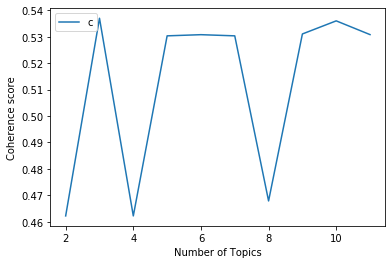

In [80]:
start,stop,step=2,12,1
plot_graph(clean_text,start,stop,step)

# Pros and Cons of LSA
LSA algorithm is the simplest method which is easy to understand and implement. It also offers better results compared to the vector space model. It is faster compared to other available algorithms because it involves document term matrix decomposition only.

Latent topic dimension depends upon the rank of the matrix so we can't extend that limit. LSA decomposed matrix is a highly dense matrix, so it is difficult to index individual dimension. LSA unable to capture the multiple meanings of words. It is not easier to implement compared to LDA (latent Dirichlet allocation). It offers lower accuracy than LDA.